In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [64]:
df = pd.read_csv("winequalityN.csv")
print(df.head())

    type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0       0.45      8.8        6  
1       0.49      9.5        6  
2       0.4

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [66]:
set(df.quality)

{3, 4, 5, 6, 7, 8, 9}

In [67]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,6487.0,7.216579,1.296750,3.80000,6.40000,7.00000,7.70000,15.90000
volatile acidity,6489.0,0.339691,0.164649,0.08000,0.23000,0.29000,0.40000,1.58000
citric acid,6494.0,0.318722,0.145265,0.00000,0.25000,0.31000,0.39000,1.66000
residual sugar,6495.0,5.444326,4.758125,0.60000,1.80000,3.00000,8.10000,65.80000
chlorides,6495.0,0.056042,0.035036,0.00900,0.03800,0.04700,0.06500,0.61100
free sulfur dioxide,6497.0,30.525319,17.749400,1.00000,17.00000,29.00000,41.00000,289.00000
total sulfur dioxide,6497.0,115.744574,56.521855,6.00000,77.00000,118.00000,156.00000,440.00000
density,6497.0,0.994697,0.002999,0.98711,0.99234,0.99489,0.99699,1.03898
pH,6488.0,3.218395,0.160748,2.72000,3.11000,3.21000,3.32000,4.01000
sulphates,6493.0,0.531215,0.148814,0.22000,0.43000,0.51000,0.60000,2.00000


In [68]:
# check the number of null values in the dataset columns wise
df.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [69]:
# input the missing values by means
# the data in different columns are continuous values
for col in df.columns:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mean())

df.isnull().sum().sum()

0

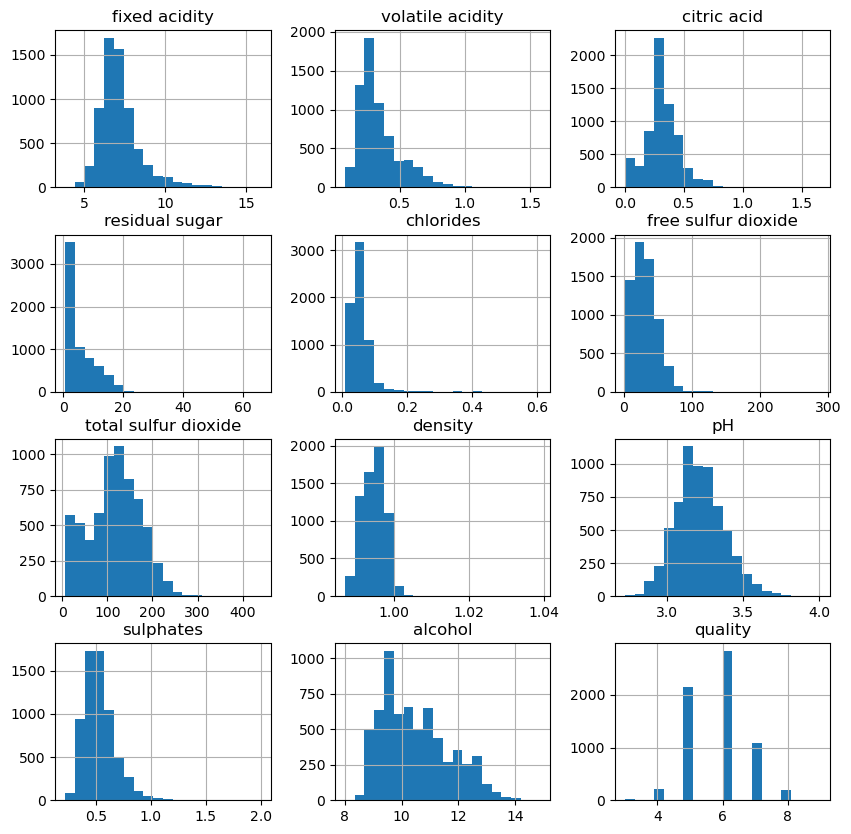

In [70]:
# use histogram to visualise the distribution of data
df.hist(bins=20, figsize=(10, 10))
plt.show()

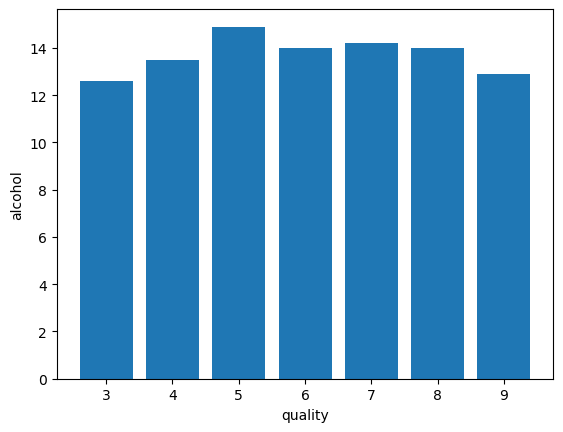

In [71]:
# draw the count plot to visualise the number data for each quality of wine
plt.bar(df['quality'], df['alcohol'])
plt.xlabel('quality')
plt.ylabel('alcohol')
plt.show()

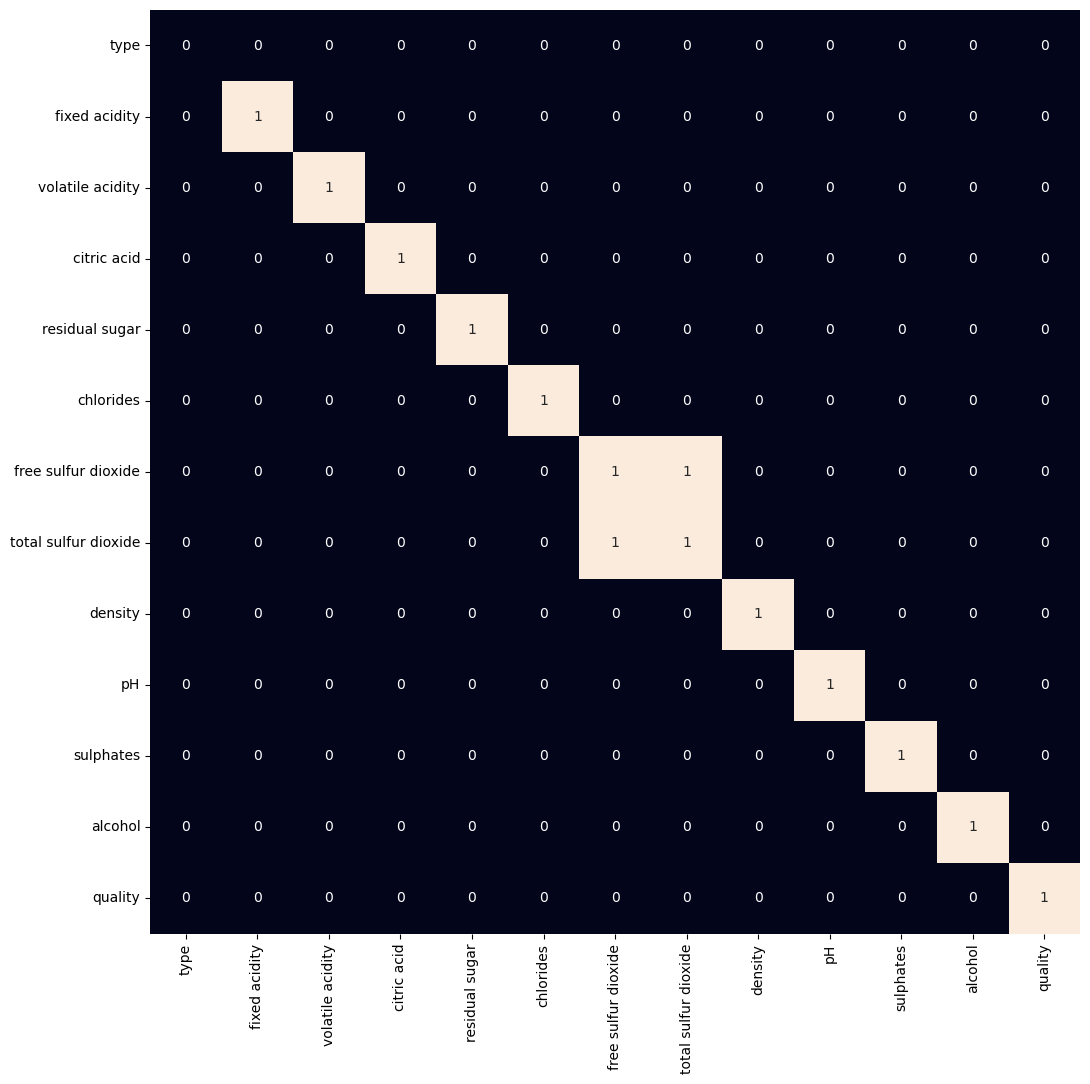

In [72]:
# convert 'object' columns to numerical if they represent numbers
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, replace non-convertibles with NaN
        except:
            pass
           
plt.figure(figsize=(12, 12))
sb.heatmap(df.corr() > 0.7, annot=True, cbar=False)
plt.show()

In [73]:
# 'total sulphur dioxide' and 'free sulphur dioxide' are highly correlated
df = df.drop('total sulfur dioxide', axis=1)

correlation matrix among all features inside the dataset

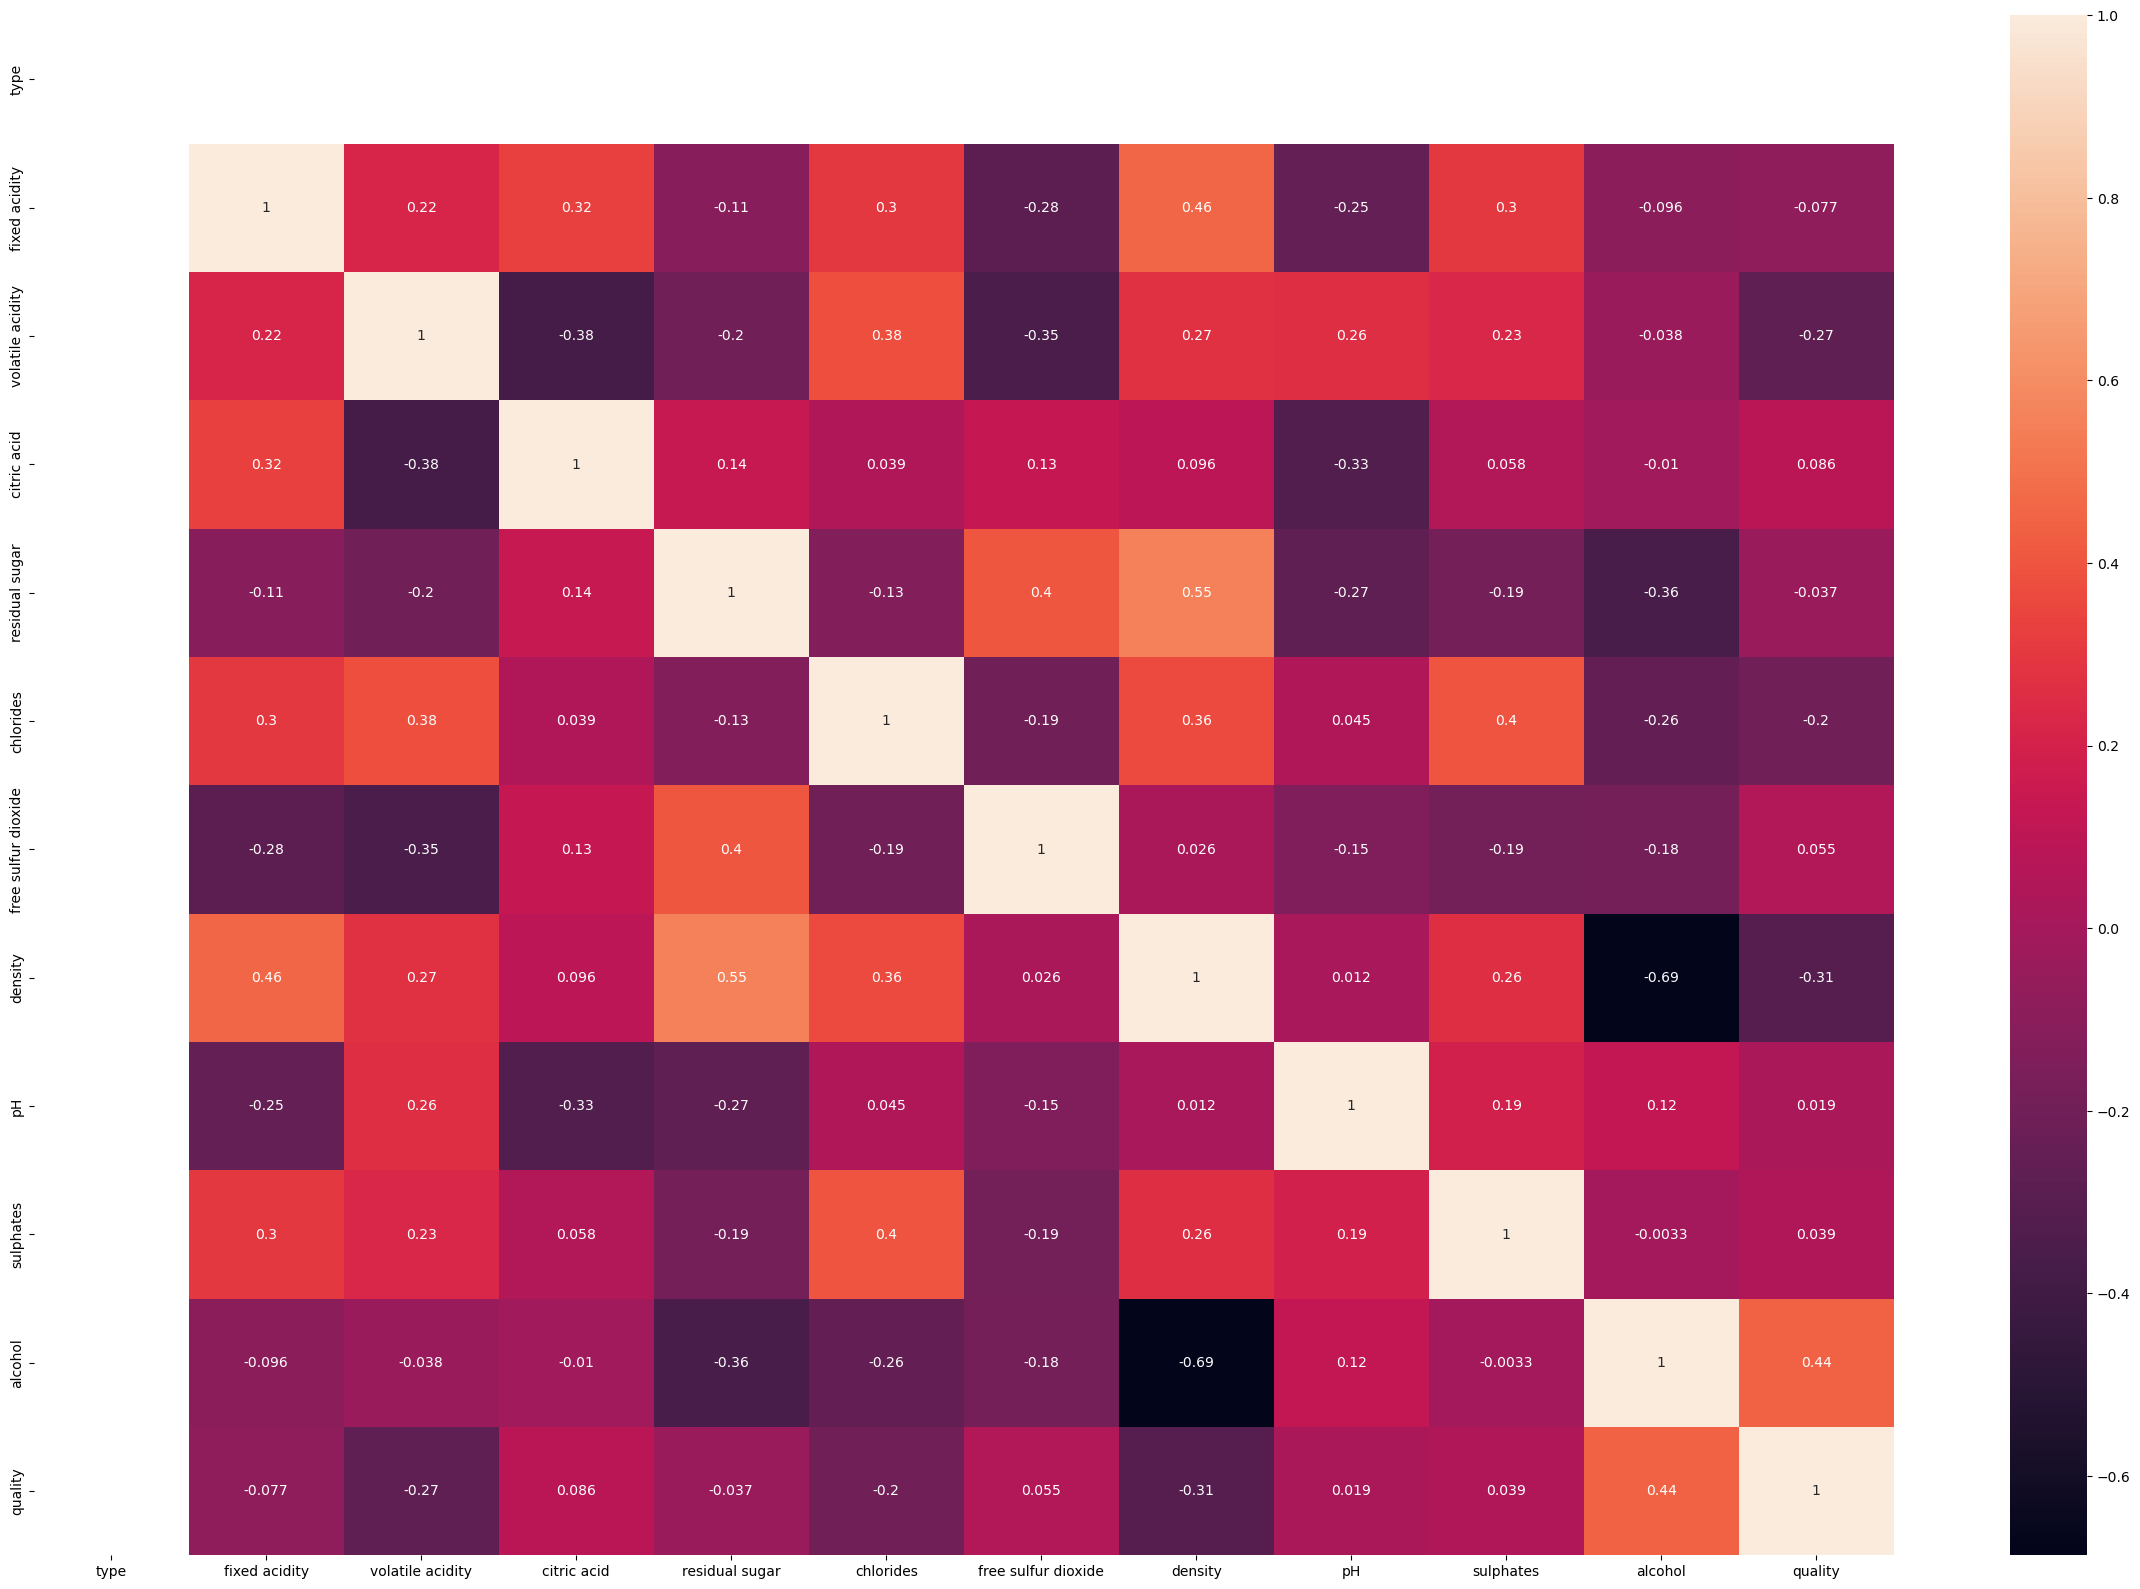

In [74]:
plt.figure(figsize=(30, 20))
corr = df.corr()
sb.heatmap(corr, annot=True)
plt.show()

# Model Development

In [75]:
df['best quality'] = [1 if x > 5 else 0 for x in df.quality]

In [80]:
df.replace({'white': 1, 'red': 0}, inplace=True)

In [85]:
# split the data into 80:20 ratio for model selection
features = df.drop(['quality', 'best quality'], axis=1)
features = features.fillna(features.mean())
target = df['best quality']

xtrain, xtest, ytrain, ytest = train_test_split(features, target, test_size=0.2, random_state=40)
imputer = SimpleImputer(strategy='mean')
xtrain = imputer.fit_transform(xtrain)
xtest = imputer.transform(xtest)

xtrain.shape, xtest.shape
# impute missing values after splitting

((5197, 10), (1300, 10))

In [86]:
# normalise the data before training
norm = MinMaxScaler()
xtrain = norm.fit_transform(xtrain)
xtest = norm.transform(xtest)

In [88]:
models = [LogisticRegression(), XGBClassifier(), SVC(kernel='rbf')]

for i in range(3):
    models[i].fit(xtrain, ytrain)

    print(f'{models[i]}: ')
    print('Training Accuracy: ', metrics.roc_auc_score(ytrain, models[i].predict(xtrain)))
    print('Validation Accuracy: ', metrics.roc_auc_score(ytest, models[i].predict(xtest)))
    print()

LogisticRegression(): 
Training Accuracy:  0.6975101024661644
Validation Accuracy:  0.6855058693719925

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...): 
Training Accuracy:  0.9762240429934201
Validation Accuracy:  0.8045662590288206

SVC(): 
Training Accuracy:  0.7203202525576721
Validati

Logistic Regression and SVC seem to perform better because of less difference between the validation and training data

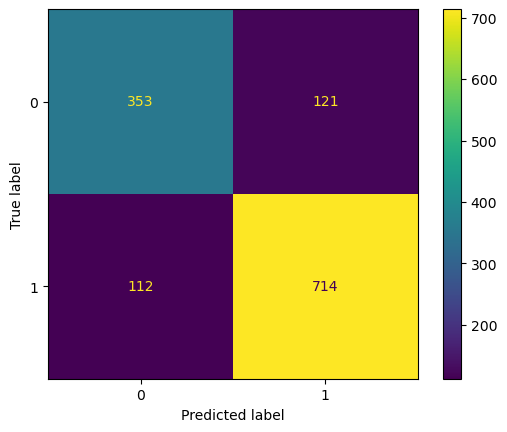

In [90]:
# Assume 'models[1] is the trained classifier
cm = confusion_matrix(ytest, models[1].predict(xtest))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=models[1].classes_)
disp.plot()
plt.show()

In [91]:
print(metrics.classification_report(ytest, models[1].predict(xtest)))

              precision    recall  f1-score   support

           0       0.76      0.74      0.75       474
           1       0.86      0.86      0.86       826

    accuracy                           0.82      1300
   macro avg       0.81      0.80      0.81      1300
weighted avg       0.82      0.82      0.82      1300

